In [1]:
# imports
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# config
%matplotlib inline

## Dataload..

In [3]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
trainset = MNIST(root='~/datasets/', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
]))
testset = MNIST(root='~/datasets/', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
]))

In [4]:
type(trainset)

torchvision.datasets.mnist.MNIST

item type: <class 'torch.Tensor'>, shape: torch.Size([1, 28, 28])
label: 4


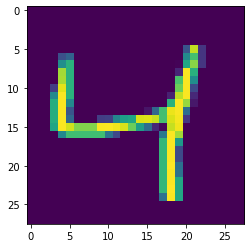

In [5]:
item = trainset.__getitem__(2)
print(f'item type: {type(item[0])}, shape: {item[0].shape}')
plt.imshow(item[0].squeeze(0));
print(f'label: {item[1]}')

In [6]:
testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/tharun_313/datasets/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [7]:
from torch.utils.data import DataLoader
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
testloader = DataLoader(testset, batch_size=8, shuffle=True)

In [8]:
type(trainloader)

torch.utils.data.dataloader.DataLoader

In [9]:
x_batch_idx, (x_data, x_labels) = next(enumerate(testloader))
x_batch_idx, x_data.shape, x_labels.shape

(0, torch.Size([8, 1, 28, 28]), torch.Size([8]))

## Neural Network

In [33]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
class MNIST_NN(nn.Module):
    def __init__(self,):
        super().__init__()
        self.pool = nn.MaxPool2d(3, stride=2)
        self.conv1 = nn.Conv2d(1, 16, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=1)
        self.fc1 = nn.Linear(32 * 6 * 6, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = MNIST_NN()

In [12]:
net

MNIST_NN(
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

## define loss function and optimizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## train the network

In [207]:
epochs = 2
for epoch in range(epochs):
    running_loss = 0.
    for batch_idx, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if batch_idx%1500 == 1499:
            print(f'[epoch: {epoch+1}, mini-batch: {batch_idx+1}], loss: {running_loss/1500}')
            running_loss = 0.

[epoch: 1, mini-batch: 1500], loss: 0.523202441776084
[epoch: 1, mini-batch: 3000], loss: 0.12563365715250013
[epoch: 1, mini-batch: 4500], loss: 0.0910641908375043
[epoch: 1, mini-batch: 6000], loss: 0.08319379382156755
[epoch: 1, mini-batch: 7500], loss: 0.08737772980580455
[epoch: 2, mini-batch: 1500], loss: 0.06710766601490915
[epoch: 2, mini-batch: 3000], loss: 0.06662023800108853
[epoch: 2, mini-batch: 4500], loss: 0.06677020643527823
[epoch: 2, mini-batch: 6000], loss: 0.06131087971993494
[epoch: 2, mini-batch: 7500], loss: 0.056376754874611086


## save the model

In [ ]:
torch.save(net.state_dict(), './models/mnist.pth')

## load the model

In [16]:
net.load_state_dict(torch.load('./models/mnist.pth'))

<All keys matched successfully>

In [21]:
testiter = iter(testloader)
images, gtruths = next(testiter)

In [23]:
images.shape, gtruths.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

In [26]:
outputs = net(images)
outputs.shape

torch.Size([8, 10])

In [30]:
scores, predicted_labels = torch.max(outputs, axis=1)
predicted_labels

tensor([9, 8, 4, 8, 9, 3, 6, 9])

In [45]:
images.expand(-1, 3, -1, -1).shape

torch.Size([8, 3, 28, 28])

tensor([9, 8, 4, 8, 9, 3, 6, 9])


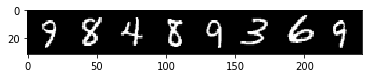

In [53]:
image_grid = torchvision.utils.make_grid(images.expand(-1, 3, -1, -1))
plt.imshow(image_grid.permute(1, 2, 0));
print(predicted_labels)

## on all test images

In [66]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        total += labels.size(0)
        _, predicted = torch.max(outputs, axis=1)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {(correct/total):.5f}')

Accuracy: 0.98530
